In [37]:
# imports
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cleantitanic2

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVC

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
jtplot.style()

In [38]:
# init picture params
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.major.size'] = 0
mpl.rcParams['ytick.major.size'] = 0

tr_raw = pd.read_csv('./data/train.csv')
te_raw = pd.read_csv('./data/test.csv')
type_dict = None

print tr_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [39]:
# init model
result_dict = {}
bingo = ['', None, 0, None]
model_dict = {
    'logistic regr': LogisticRegression(),
    'decision tree': DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5),
    'svm rbf   ': SVC()
    #'random forest': RandomForestClassifier(n_estimators=1000,random_state=33)
}

# bagging
#for k, v in model_dict.items():
#    model_dict[k] = BaggingRegressor(v, n_estimators=20, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)

tr_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [40]:
tr_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# simple clean
[tr_clean, te_clean] = map(lambda x:x.fillna(0), [tr_raw, te_raw])
[tr_clean.Sex, te_clean.Sex] = map(lambda x:pd.get_dummies(x['Sex'], prefix='Sex'), [tr_clean, te_clean])
[tr_plt, te_plt] = [tr_clean, te_clean]

fig=plt.figure('Taitanic', figsize=(12, 6))
tr_plt_y_female = tr_plt[tr_plt.Sex==1][['Survived']]
tr_plt_female = tr_plt[tr_plt.Sex==1]
tr_plt_y_male = tr_plt[tr_plt.Sex==0][['Survived']]
tr_plt_male = tr_plt[tr_plt.Sex==0]

# real data, female, pclass, age
ax = fig.add_subplot(121, projection='3d')
ax.set_title('female')
ax.scatter(tr_plt_female['Fare'], tr_plt_female['Age'], tr_plt_female['Pclass'], c=tr_plt_y_female.values.ravel(), edgecolors='k', cmap=plt.cm.Paired)
ax.set_zticklabels(['1st', '', '2nd', '', '3rd'])
ax.set_ylabel('age(years)')

# cross validate predict data, female, pclass, age
bx = fig.add_subplot(122, projection='3d')
bx.set_title('male')
bx.scatter(tr_plt_male['Fare'], tr_plt_male['Age'], tr_plt_male['Pclass'], c=tr_plt_y_male.values.ravel(), edgecolors='k', cmap=plt.cm.Paired)
bx.set_zticklabels(['1st', '', '2nd', '', '3rd'])
bx.set_ylabel('age(years)')
plt.show()

# feature chose
[tr_X, te_X] = map(lambda x:x[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']], [tr_clean, te_clean])

tr_plt.head()

In [41]:
# feature engineering
# https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
if not type_dict:
    [tr_clean, te_clean, type_dict] = cleantitanic2.clean(tr_raw, te_raw)
    
tr_clean

,Age,AgeXClass,Cabin,Deck,Embarked,Family_Size,Fare,Fare_Per_Person,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,"(21.0, 24.0]","(62.0, 72.0]",Unknown,Unknown,S,1,"(3.17, 7.733]","(1.11, 5.567]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,"(32.0, 39.0]","(36.0, 48.0]",C85,C,C,1,"(46.06, 79.2]","(27.35, 43.833]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,"(24.0, 28.0]","(72.0, 89.097]",Unknown,Unknown,S,0,"(7.879, 8.05]","(7.896, 8.662]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,"(32.0, 39.0]","(26.0, 36.0]",C123,C,S,1,"(46.06, 79.2]","(14.458, 27.35]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,"(32.0, 39.0]","(99.0, 222.0]",Unknown,Unknown,S,0,"(7.879, 8.05]","(7.896, 8.662]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr
5,"(28.0, 29.699]","(72.0, 89.097]",Unknown,Unknown,Q,0,"(8.05, 11.5]","(7.896, 8.662]","Moran, Mr. James",0,6,3,male,0,0.0,330877,Mr
6,"(48.0, 80.0]","(48.0, 54.0]",E46,E,S,0,"(46.06, 79.2]","(43.833, 512.329]","McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,Mr
7,"(0.169, 16.0]","(0.509, 26.0]",Unknown,Unknown,S,4,"(14.5, 22.358]","(1.11, 5.567]","Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,Master
8,"(24.0, 28.0]","(72.0, 89.097]",Unknown,Unknown,S,2,"(8.05, 11.5]","(1.11, 5.567]","Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,Mrs
9,"(0.169, 16.0]","(26.0, 36.0]",Unknown,Unknown,C,1,"(27.721, 46.06]","(14.458, 27.35]","Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,Mrs


<IPython.core.display.Javascript object>


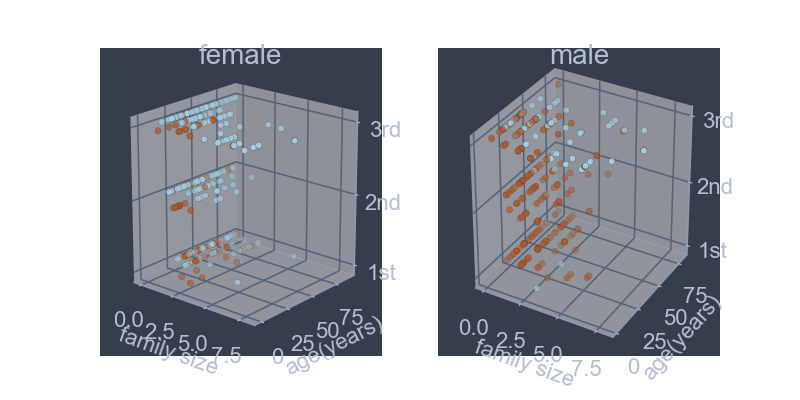

In [47]:
# label encoder
[tr_clean, te_clean] = map(lambda x:x.apply(LabelEncoder().fit_transform), [tr_clean, te_clean])
[tr_plt, te_plt] = map(lambda x:x.apply(LabelEncoder().fit_transform), [tr_raw, te_raw])

fig=plt.figure('Taitanic', figsize=(8, 4))
tr_plt_female = tr_plt[tr_plt.Sex==1]
tr_plt_y_female = tr_plt_female[['Survived']]
tr_plt_male = tr_plt[tr_plt.Sex==0]
tr_plt_y_male = tr_plt_male[['Survived']]

# real data, female, pclass, age
ax = fig.add_subplot(121, projection='3d')
ax.set_title('female')
ax.scatter(tr_plt_female['Family_Size'], tr_plt_female['Age'], tr_plt_female['Pclass'], c=tr_plt_y_female.values.ravel(), edgecolors='k', cmap=plt.cm.Paired)
ax.set_zticklabels(['1st', '2nd', '3rd'])
ax.set_xlabel('family size')
ax.set_ylabel('age(years)')

# real data, male, pclass, age
bx = fig.add_subplot(122, projection='3d')
bx.set_title('male')
bx.scatter(tr_plt_male['Family_Size'], tr_plt_male['Age'], tr_plt_male['Pclass'], c=tr_plt_y_male.values.ravel(), edgecolors='k', cmap=plt.cm.Paired)
bx.set_zticklabels(['1st', '2nd', '3rd'])
bx.set_xlabel('family size')
bx.set_ylabel('age(years)')

# feature chose
[tr_X, te_X] = map(lambda x:x[['Pclass', 'Sex', 'Age', 'Family_Size', 'Title']], [tr_clean, te_clean])

In [43]:
# train
tr_y = tr_clean[['Survived']]
for k, v in model_dict.items():
    v.fit(tr_X, tr_y.values.ravel())

<IPython.core.display.Javascript object>


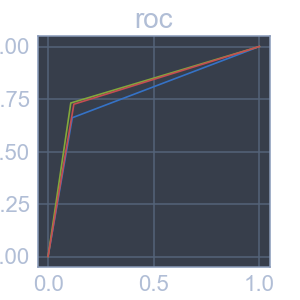

logistic regr 	ACU: 0.799102132435 AUC: 0.773032307545 MSE: 0.200897867565 RMSE: 0.448216317825
svm rbf    	ACU: 0.830527497194 AUC: 0.811763014093 MSE: 0.169472502806 RMSE: 0.411670381259
decision tree 	ACU: 0.819304152637 AUC: 0.801553062985 MSE: 0.180695847363 RMSE: 0.425083341667
BINGO: svm rbf    ACU: 0.830527497194


In [44]:
# metrics
fig=plt.figure('Roc', figsize=(3, 3))
cx = fig.add_subplot(111)
cx.set_title('roc')

for k, v in model_dict.items():
    pred_y_cv = cross_val_predict(v, tr_X, tr_y, cv=10)
    acu = metrics.accuracy_score(tr_y, pred_y_cv.astype(np.int32))
    auc = metrics.roc_auc_score(tr_y, pred_y_cv.astype(np.int32))
    if acu > bingo[2]:
        bingo[0] = k
        bingo[1] = v
        bingo[2] = acu
        bingo[3] = pred_y_cv
    print k, "\tACU:", acu, "AUC:", auc, \
        "MSE:", metrics.mean_squared_error(tr_y, pred_y_cv), "RMSE:", np.sqrt(metrics.mean_squared_error(tr_y, pred_y_cv))
    
    # paint ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(tr_y, pred_y_cv)
    cx.plot(fpr,tpr)

# bingo
print "BINGO:", bingo[0], "ACU:", bingo[2]
#pd.DataFrame([bingo[1].coef_], columns=list(tr_X))

In [45]:
# predict
pred_y = bingo[1].predict(te_X)

# write csv
id = te_raw[['PassengerId']]
frames = [id, pd.DataFrame(pred_y.astype(np.int32), columns=['Survived'])]
out_y = pd.concat(frames, axis=1, join_axes=[id.index])
out_y.to_csv('out.csv', index=False)